<a href="https://colab.research.google.com/github/Vincent-Kwan/Safe-Roads-Competition/blob/master/Pedestrian_Stupidity_Redux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
%matplotlib inline

from pathlib import Path
import math
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
import matplotlib.pylab as plt
!pip install dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary, adjusted_r2_score, AIC_score, forward_selection, backward_elimination
!pip install scikit-plot
import scikitplot as skplt

In [21]:
fixed_url = 'https://raw.githubusercontent.com/Vincent-Kwan/Safe-Roads-Competition/master/Data/Created%20datasets/Pedestrian_Feature_Count.csv'

In [22]:
pedestrians = pd.read_csv(fixed_url)
pedestrians.head()

,Unnamed: 0,LATITUDE,LONGITUDE,PEDTYPE,PEDACT,PEDCOND,TRAFFCTL,LIGHT,VISIBILITY,RDSFCOND,TIME,COUNT
0,0,43.594,-79.533,Vehicle is going straight thru inter.while ped...,Crossing marked crosswalk without ROW,Inattentive,Traffic Signal,Daylight,Clear,Dry,1367.000000,2
1,1,43.594,-79.533,Vehicle turns left while ped crosses with ROW ...,Crossing with right of way,Normal,Traffic Signal,Dusk,Clear,Dry,1367.000000,2
2,2,43.595,-79.528,<Null>,Other,Other,No Control,"Dark, artificial",Clear,Dry,1949.000000,1
3,3,43.597,-79.522,Vehicle is reversing and hits pedestrian,Other,Normal,No Control,Daylight,Clear,Dry,600.000000,1
4,4,43.598,-79.516,Vehicle is going straight thru inter.while ped...,Running onto Roadway,Normal,Traffic Signal,Dark,Rain,Wet,1956.333333,2


In [ ]:
import seaborn as sns

In [ ]:
pedestrians['PEDCOND'].unique()

array(['Inattentive', 'Normal', 0, 'Unknown', 'Had Been Drinking',
       'Ability Impaired, Alcohol', 'Medical or Physical Disability',
       'Ability Impaired, Alcohol Over .80', 'Fatigue',
       'Ability Impaired, Drugs'], dtype=object)

In [ ]:
pedestrians = pedestrians.sort_values(["b, "c"], ascending = (False, True))

ValueError: ignored

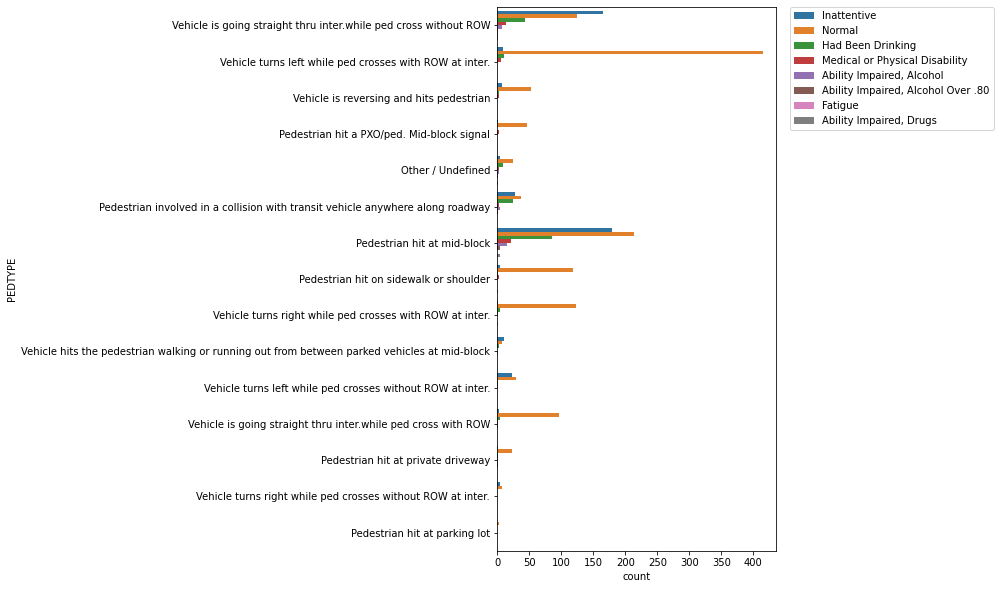

In [ ]:
plt.figure(figsize = (5,10))
sns.countplot(data = pedestrians[(pedestrians['PEDCOND'] != 'Unknown') & 
                                 (pedestrians['PEDCOND'] != 0) & 
                                 (pedestrians['PEDTYPE'] != '<Null>') &
                                 (pedestrians['PEDTYPE'] != 0) &
                                 (pedestrians['PEDTYPE'] != 'Unknown')], y = 'PEDTYPE', hue = 'PEDCOND')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
pedestrians = pedestrians.replace('Yes', 1).replace('<Null>', 'Other').replace('<Null', 'Other').replace(0, 'Other')

In [ ]:
pedestrians.head()

,Unnamed: 0,LATITUDE,LONGITUDE,PEDTYPE,PEDACT,PEDCOND,TRAFFCTL,LIGHT,VISIBILITY,RDSFCOND,TIME,COUNT
0,Other,43.594,-79.533,Vehicle is going straight thru inter.while ped...,Crossing marked crosswalk without ROW,Inattentive,Traffic Signal,Daylight,Clear,Dry,1367.0,2
1,1,43.594,-79.533,Vehicle turns left while ped crosses with ROW ...,Crossing with right of way,Normal,Traffic Signal,Dusk,Clear,Dry,1367.0,2
2,2,43.595,-79.528,Other,Other,Other,No Control,"Dark, artificial",Clear,Dry,1949.0,1
3,3,43.597,-79.522,Vehicle is reversing and hits pedestrian,Other,Normal,No Control,Daylight,Clear,Dry,600.0,1
4,4,43.598,-79.516,Vehicle is going straight thru inter.while ped...,Running onto Roadway,Normal,Traffic Signal,Dark,Rain,Wet,1956.333333,2


In [24]:
pedestrians = pedestrians.replace('Crossing marked crosswalk without ROW', 1).replace('Running onto Roadway', 1).replace('Crossing, no Traffic Control', 1).replace(
    'Crossing without right of way', 1).replace('Walking on Roadway Against Traffic', 1).replace('Walking on Roadway with Traffic', 1).replace('Playing or Working on Highway', 1)

In [25]:
pedestrians = pedestrians.replace('Crossing with right of way', 0).replace('Pushing/Working on Vehicle', 0).replace('On Sidewalk or Shoulder', 0).replace(
    'Coming From Behind Parked Vehicle', 0).replace('Person Getting on/off Vehicle', 0).replace('Crossing, Pedestrian Crossover', 0).replace('Person Getting on/off School Bus', 0).replace('Other', 0)

In [ ]:
outcome = 'COUNT'
predictors = ['PEDTYPE', 'PEDCOND', 'PEDACT', 'TRAFFCTL', 'LIGHT', 'VISIBILITY', 'RDSFCOND']
x = pd.get_dummies(pedestrians[predictors], drop_first = True)
y = pedestrians[outcome]

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

In [ ]:
reg = LinearRegression()
reg.fit(train_x, train_y)

LinearRegression()

In [ ]:
reg.coef_

array([-2.38052675e-02,  6.35071108e-02, -5.96679319e-02, -7.94693568e-02,
        5.40104190e-01,  5.69421224e-02, -9.16702793e-02,  5.36719855e-02,
       -3.39705135e-02, -4.04343981e-01, -1.84618826e-01, -1.54353805e-01,
       -1.34174534e-01, -3.20952033e-01,  8.65063568e-02, -3.91676634e-01,
       -1.36679727e-02, -2.41273380e-01,  4.45149521e-01,  9.54183179e-02,
        1.41787729e-01,  1.49936680e-02, -1.55874943e-02,  1.92790889e-02,
       -3.92147066e-02,  1.02459123e-01, -1.85593840e+00, -1.91437006e+00,
       -6.70574707e-14, -1.99488218e+00, -1.94855943e+00, -2.24328059e+00,
       -1.91253922e+00, -2.52101515e+00, -1.21191879e+00, -1.12916157e+00,
       -2.21456438e-01, -1.70402164e-01,  3.87921739e-01, -3.51419773e-01,
       -1.82052073e-01, -5.42451945e-01, -1.68949573e-01, -1.00715473e-01,
        2.11045113e-01,  9.88181529e-01,  3.11101679e-01, -1.83106379e-01,
        3.23801996e-01,  3.86710167e-02, -2.59503170e-01,  1.44003802e-01,
       -2.20265667e-02,  

In [ ]:
regressionSummary(train_y, reg.predict(train_x))
regressionSummary(valid_y, reg.predict(valid_x))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.9122
            Mean Absolute Error (MAE) : 0.6430
          Mean Percentage Error (MPE) : -21.3681
Mean Absolute Percentage Error (MAPE) : 42.3427

Regression statistics

                      Mean Error (ME) : 0.0430
       Root Mean Squared Error (RMSE) : 1.0062
            Mean Absolute Error (MAE) : 0.7056
          Mean Percentage Error (MPE) : -21.0086
Mean Absolute Percentage Error (MAPE) : 44.4169


In [ ]:
adjusted_r2_score(valid_y, reg.predict(valid_x), reg)

0.0045306633046487965

In [ ]:
pedestrians.skew(axis = 1, skipna = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


0       2.421148
1       2.421148
2       2.435525
3       2.304904
4       2.435498
          ...   
2543    1.495192
2544    1.495658
2545    2.055305
2546    1.035612
2547    1.008896
Length: 2548, dtype: float64

In [ ]:
pred_error_train = pd.DataFrame({ 
 'residual': train_y - reg.predict(train_x), 
 'data set': 'training' 
}) 

In [ ]:
pred_error_train.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


residual    2.307609
dtype: float64

In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 564 kB 3.8 MB/s 


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

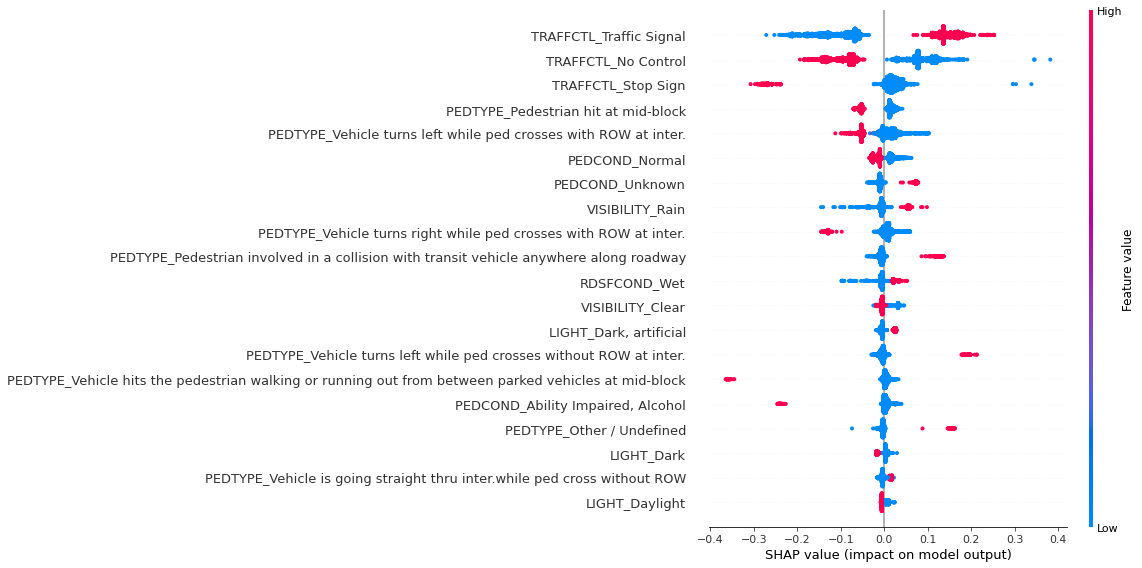

In [ ]:
explainer = shap.Explainer(reg, masker=shap.maskers.Impute(data= train_x),
                           feature_names= train_x.columns, algorithm="linear")
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)

In [ ]:
pd.DataFrame({'Actual': valid_y, 'Predicted': reg.predict(valid_x)})

,Actual,Predicted
81,1,1.457709
107,1,1.984839
1297,1,1.535053
2264,1,1.380248
645,1,1.380426
...,...,...
1385,1,1.712239
11,1,1.305364
210,1,1.419641
2124,2,1.356621


(0.6499999999999999, 8.35, 0.5461733916942159, 3.489315226356875)

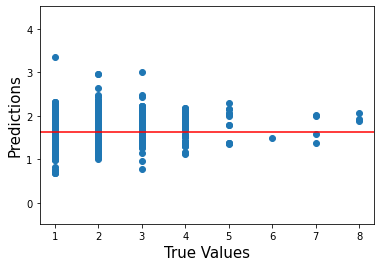

In [ ]:
predicted_value = reg.predict(valid_x)
plt.scatter(valid_y, reg.predict(valid_x))
plt.axhline(y = y.mean(), color = 'r', linestyle = '-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')

In [ ]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_x[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_x[variables]), model)

best_model, best_variables = forward_selection(train_x.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: PEDTYPE_Other / Undefined, PEDTYPE_Pedestrian hit a PXO/ped. Mid-block signal, PEDTYPE_Pedestrian hit at mid-block, PEDTYPE_Pedestrian hit at parking lot, PEDTYPE_Pedestrian hit at private driveway, PEDTYPE_Pedestrian hit on sidewalk or shoulder, PEDTYPE_Pedestrian involved in a collision with transit vehicle anywhere along roadway, PEDTYPE_Unknown, PEDTYPE_Vehicle hits the pedestrian walking or running out from between parked vehicles at mid-block, PEDTYPE_Vehicle is going straight thru inter.while ped cross with ROW, PEDTYPE_Vehicle is going straight thru inter.while ped cross without ROW, PEDTYPE_Vehicle is reversing and hits pedestrian, PEDTYPE_Vehicle turns left while ped crosses with ROW at inter., PEDTYPE_Vehicle turns left while ped crosses without ROW at inter., PEDTYPE_Vehicle turns right while ped crosses with ROW at inter., PEDTYPE_Vehicle turns right while ped crosses without ROW at inter., PEDCOND_Ability Impaired, Alcohol, PEDCOND_Ability Impaired, Alcohol Ove

In [ ]:
regressionSummary(valid_y, best_model.predict(valid_x[best_variables]))


Regression statistics

                      Mean Error (ME) : 0.0491
       Root Mean Squared Error (RMSE) : 1.0087
            Mean Absolute Error (MAE) : 0.7064
          Mean Percentage Error (MPE) : -20.9395
Mean Absolute Percentage Error (MAPE) : 44.4824


In [ ]:
clf = MLPRegressor(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=3, random_state=1, max_iter=5000)
clf.fit(train_x, train_y)

MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=5000,
             random_state=1, solver='lbfgs')

In [ ]:
clf.predict(train_x)

array([ 0.3885081 ,  0.20099081,  0.3885081 , ..., -0.00261926,
        0.50264577,  0.50474785])

In [ ]:
regressionSummary(train_y, clf.predict(train_x))
regressionSummary(valid_y, clf.predict(valid_x))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.4023
     Mean Absolute Error (MAE) : 0.3251

Regression statistics

               Mean Error (ME) : -0.0034
Root Mean Squared Error (RMSE) : 0.4256
     Mean Absolute Error (MAE) : 0.3385


In [ ]:
pedestrians['PEDACT'].unique()

array(['Crossing marked crosswalk without ROW',
       'Crossing with right of way', 'Other', 'Running onto Roadway',
       'Pushing/Working on Vehicle', 'Crossing, no Traffic Control',
       'Crossing without right of way', '<Null>',
       'Walking on Roadway Against Traffic', 'On Sidewalk or Shoulder',
       'Walking on Roadway with Traffic',
       'Coming From Behind Parked Vehicle',
       'Person Getting on/off Vehicle', 'Crossing, Pedestrian Crossover',
       'Playing or Working on Highway',
       'Person Getting on/off School Bus'], dtype=object)

In [ ]:
pedestrians.head()

,Unnamed: 0,LATITUDE,LONGITUDE,PEDTYPE,PEDACT,PEDCOND,TRAFFCTL,LIGHT,VISIBILITY,RDSFCOND,TIME,COUNT
0,0,43.594,-79.533,Vehicle is going straight thru inter.while ped...,1,Inattentive,Traffic Signal,Daylight,Clear,Dry,1367.000000,2
1,1,43.594,-79.533,Vehicle turns left while ped crosses with ROW ...,0,Normal,Traffic Signal,Dusk,Clear,Dry,1367.000000,2
2,2,43.595,-79.528,0,0,0,No Control,"Dark, artificial",Clear,Dry,1949.000000,1
3,3,43.597,-79.522,Vehicle is reversing and hits pedestrian,0,Normal,No Control,Daylight,Clear,Dry,600.000000,1
4,4,43.598,-79.516,Vehicle is going straight thru inter.while ped...,1,Normal,Traffic Signal,Dark,Rain,Wet,1956.333333,2


In [26]:
predictors = ['PEDCOND', 'TRAFFCTL', 'LIGHT', 'VISIBILITY', 'RDSFCOND']
outcome = 'PEDACT'

x = pd.get_dummies(pedestrians[predictors])
y = pedestrians[outcome]

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

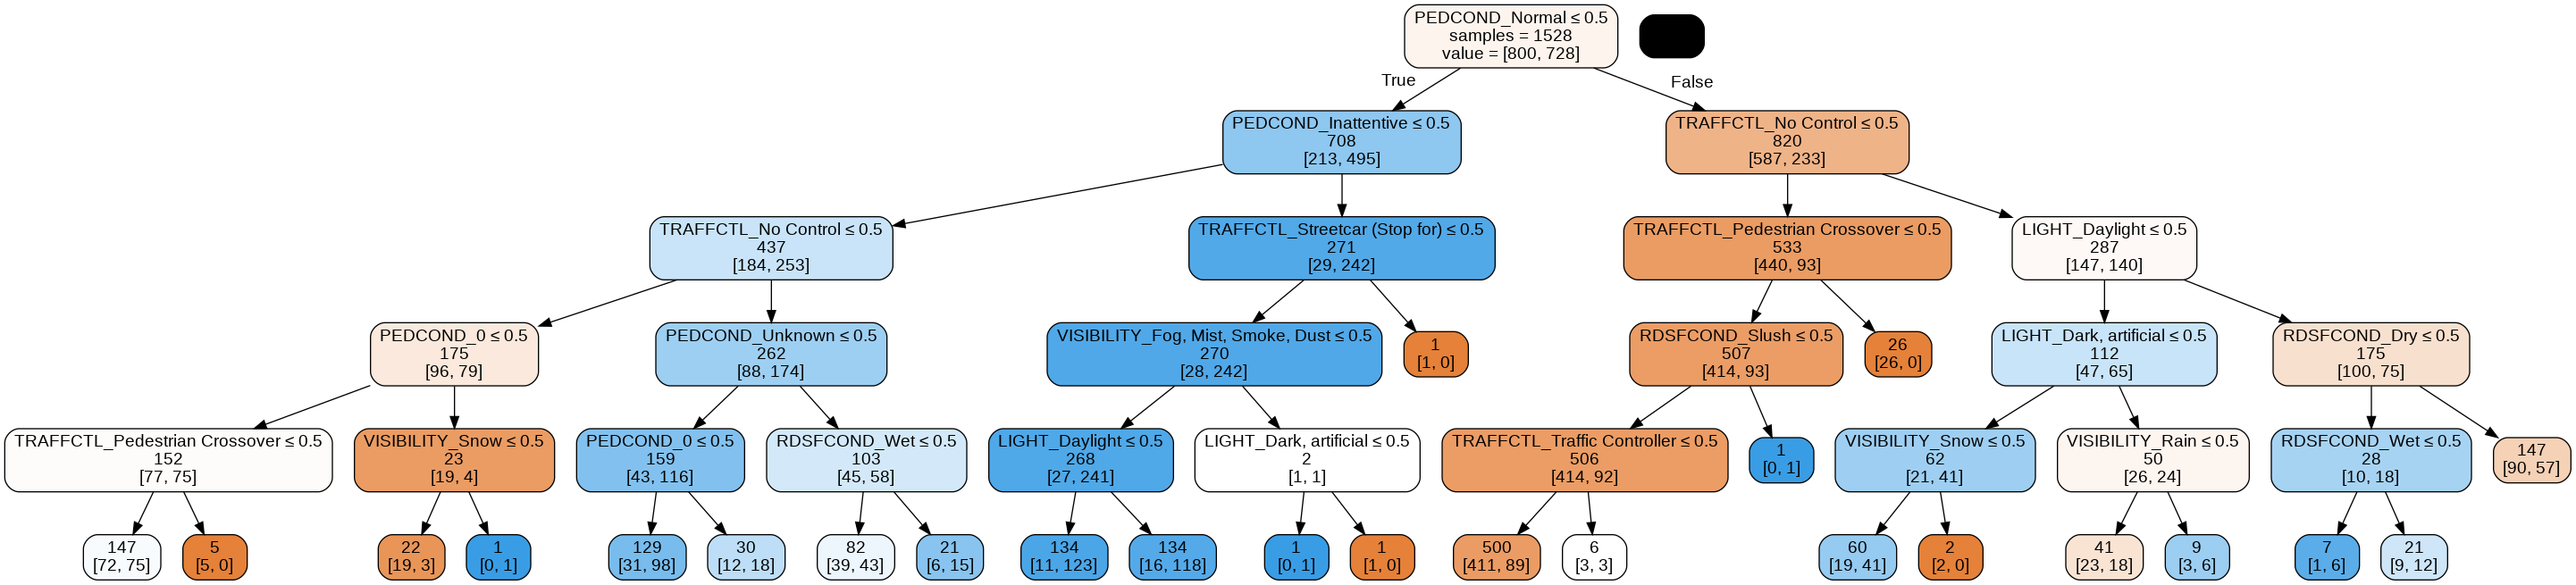

In [ ]:
smallClassTree = DecisionTreeClassifier(max_depth=5, random_state=1)
smallClassTree.fit(train_x,train_y)
plotDecisionTree(smallClassTree, feature_names=train_x.columns)

In [ ]:
classificationSummary(valid_y,smallClassTree.predict(valid_x))

Confusion Matrix (Accuracy 0.7343)

       Prediction
Actual   0   1
     0 379 158
     1 113 370


In [27]:
param_grid = { 
 'max_depth': [3, 2, 4, 5, 6, 7, 8,10, 11, 12, 13, 14, 15], 
 'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001], 
 'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005] 
} 

In [28]:
gridsearch = GridSearchCV(DecisionTreeRegressor(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14,
                                       15],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001],
                         'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005]})

In [29]:
regtree = gridsearch.best_estimator_

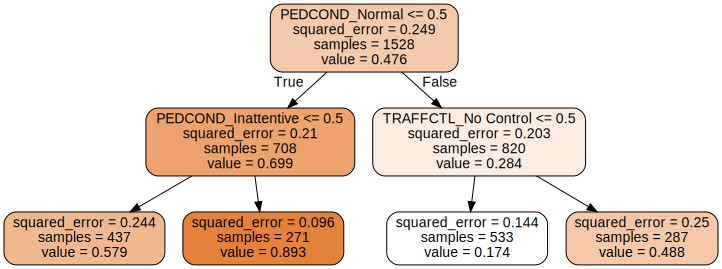

In [30]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(regtree, 
                           feature_names=valid_x.columns, 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph

In [33]:
import numpy as np

In [31]:
regressionSummary(valid_y, regtree.predict(valid_x))


Regression statistics

               Mean Error (ME) : -0.0027
Root Mean Squared Error (RMSE) : 0.4170
     Mean Absolute Error (MAE) : 0.3582


In [35]:
y.mean()

0.47527472527472525

In [36]:
regressionSummary(valid_y, np.repeat(y.mean(), valid_y.shape))


Regression statistics

               Mean Error (ME) : -0.0017
Root Mean Squared Error (RMSE) : 0.4993
     Mean Absolute Error (MAE) : 0.4987


In [ ]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)


In [ ]:
rf = RandomForestClassifier(random_state=1, n_estimators=1000)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=1000, random_state=1)

In [ ]:
importance = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

Text(0.5, 1.0, 'Visualizing Important Features')

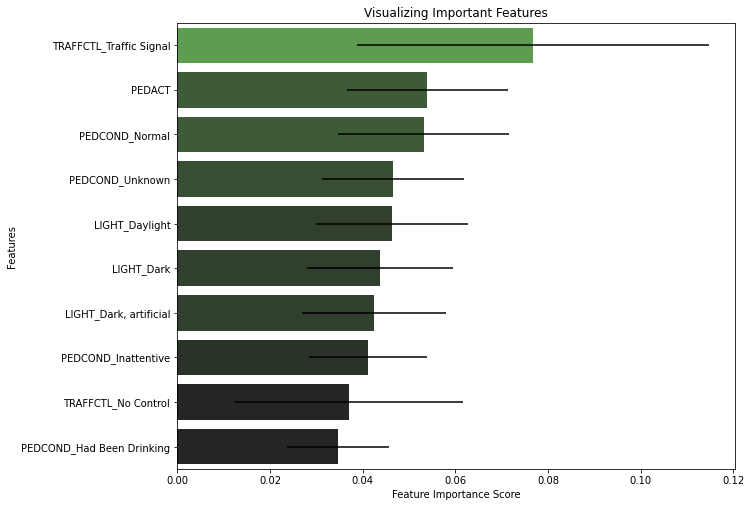

In [ ]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0) 
tf = pd.DataFrame({'feature': train_x.columns, 'importance': rf.feature_importances_, 'std': std}) 
tf = tf.sort_values('importance', ascending = False)
plt.figure(figsize = (10,8.2))
c = colors_from_values(tf['importance'][:10], "dark:#5A4")
sns.barplot(x = tf['importance'][:10], y = tf['feature'][:10], xerr = tf['std'][:10], palette = c)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
pedestrians['PEDTYPE'].unique()

array(['Vehicle is going straight thru inter.while ped cross without ROW',
       'Vehicle turns left while ped crosses with ROW at inter.', 0,
       'Vehicle is reversing and hits pedestrian',
       'Pedestrian hit a PXO/ped. Mid-block signal',
       'Pedestrian hit at mid-block', 'Other / Undefined',
       'Pedestrian involved in a collision with transit vehicle anywhere along roadway',
       'Unknown', 'Pedestrian hit on sidewalk or shoulder',
       'Vehicle turns right while ped crosses with ROW at inter.',
       'Vehicle hits the pedestrian walking or running out from between parked vehicles at mid-block',
       'Vehicle turns left while ped crosses without ROW at inter.',
       'Vehicle is going straight thru inter.while ped cross with ROW',
       'Pedestrian hit at private driveway',
       'Vehicle turns right while ped crosses without ROW at inter.',
       'Pedestrian hit at parking lot'], dtype=object)